# Text classification with Pytorch

The goal of this TP is double: an introduction to using Pytorch for treating textual data, and implementing neural classification models that we can apply to IMDB data - and then compare to models implemented in the previous TPs. 

In [89]:
import torch
import torch.nn as nn

import pandas as pd
from matplotlib import pyplot as plt
from time import time

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### A (very small) introduction to pytorch

Pytorch Tensors are very similar to Numpy arrays, with the added benefit of being usable on GPU. For a short tutorial on various methods to create tensors of particular types, see [this link](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).
The important things to note are that Tensors can be created empty, from lists, and it is very easy to convert a numpy array into a pytorch tensor, and inversely.

In [38]:
a = torch.LongTensor(5)
b = torch.LongTensor([5])

print(a)
print(b)

tensor([140296724941936,      2402308976,              32,             128,
             2402309008])
tensor([5])


In [39]:
a = torch.FloatTensor([2])
b = torch.FloatTensor([3])

print(a + b)

tensor([5.])


The main interest in us using Pytorch is the ```autograd``` package. ```torch.Tensor```objects have an attribute ```.requires_grad```; if set as True, it starts to track all operations on it. When you finish your computation, can call ```.backward()``` and all the gradients are computed automatically (and stored in the ```.grad``` attribute).

One way to easily cut a tensor from the computational once it is not needed anymore is to use ```.detach()```.
More info on automatic differentiation in pytorch on [this link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py).

In [40]:
x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

# Build a computational graph.
y = w * x + b    # y = 2 * x + 3

# Compute gradients.
y.backward()

# Print out the gradients.
print(x.grad)    # x.grad = 2 
print(w.grad)    # w.grad = 1 
print(b.grad)    # b.grad = 1 

tensor(2.)
tensor(1.)
tensor(1.)


In [41]:
x = torch.randn(10, 3)
y = torch.randn(10, 2)

# Build a fully connected layer.
linear = nn.Linear(3, 2)
for name, p in linear.named_parameters():
    print(name)
    print(p)

# Build loss function - Mean Square Error
criterion = nn.MSELoss()

# Forward pass.
pred = linear(x)

# Compute loss.
loss = criterion(pred, y)
print('Initial loss: ', loss.item())

# Backward pass.
loss.backward()

# Print out the gradients.
print ('dL/dw: ', linear.weight.grad) 
print ('dL/db: ', linear.bias.grad)

weight
Parameter containing:
tensor([[ 0.0973, -0.0238, -0.1063],
        [ 0.3875, -0.2733, -0.5385]], requires_grad=True)
bias
Parameter containing:
tensor([0.0034, 0.3485], requires_grad=True)
Initial loss:  1.3634716272354126
dL/dw:  tensor([[ 0.7983,  0.1255, -0.6623],
        [ 1.1420,  0.1786, -0.8233]])
dL/db:  tensor([-0.2962, -0.2605])


In [42]:
# You can perform gradient descent manually, with an in-place update ...
linear.weight.data.sub_(0.01 * linear.weight.grad.data)
linear.bias.data.sub_(0.01 * linear.bias.grad.data)

# Print out the loss after 1-step gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after one update: ', loss.item())

Loss after one update:  1.331282377243042


In [43]:
# Use the optim package to define an Optimizer that will update the weights of the model.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

# By default, gradients are accumulated in buffers( i.e, not overwritten) whenever .backward()
# is called. Before the backward pass, we need to use the optimizer object to zero all of the
# gradients.
optimizer.zero_grad()
loss.backward()

# Calling the step function on an Optimizer makes an update to its parameters
optimizer.step()

# Print out the loss after the second step of gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after two updates: ', loss.item())

Loss after two updates:  1.3007338047027588


### Tools for data processing 

```torch.utils.data.Dataset``` is an abstract class representing a dataset. Your custom dataset should inherit ```Dataset``` and override the following methods:
- ```__len__``` so that ```len(dataset)``` returns the size of the dataset.
- ```__getitem__``` to support the indexing such that ```dataset[i]``` can be used to get the i-th sample

Here is a toy example: 

In [44]:
toy_corpus = ['I walked down down the boulevard',
              'I walked down the avenue',
              'I ran down the boulevard',
              'I walk down the city',
              'I walk down the the avenue']

toy_categories = [0, 0, 1, 0, 0]

In [45]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    # A pytorch dataset class for holding data for a text classification task.
    def __init__(self, data, categories):
        # Upon creating the Dataset object, store the data in an attribute
        # Split the text data and labels from each other
        self.X, self.Y = [], []
        for x, y in zip(data, categories):
            # We will propably need to preprocess the data - have it done in a separate method
            # We do it here because we might need corpus-wide info to do the preprocessing 
            # For example, cutting all examples to the same length
            self.X.append(self.preprocess(x))
            self.Y.append(y)
                
    # Method allowing you to preprocess data                      
    def preprocess(self, text):
        text_pp = text.lower().strip()
        return text_pp
    
    # Overriding the method __len__ so that len(CustomDatasetName) returns the number of data samples                     
    def __len__(self):
        return len(self.Y)
   
    # Overriding the method __getitem__ so that CustomDatasetName[i] returns the i-th sample of the dataset                      
    def __getitem__(self, idx):
           return self.X[idx], self.Y[idx]

In [46]:
toy_dataset = CustomDataset(toy_corpus, toy_categories)

In [47]:
print(len(toy_dataset))
for i in range(len(toy_dataset)):
    print(toy_dataset[i])

5
('i walked down down the boulevard', 0)
('i walked down the avenue', 0)
('i ran down the boulevard', 1)
('i walk down the city', 0)
('i walk down the the avenue', 0)


```torch.utils.data.DataLoader``` is what we call an iterator, which provides very useful features:
- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.
and can be created very simply from a ```Dataset```. Continuing on our simple example: 

In [48]:
toy_dataloader = DataLoader(toy_dataset, batch_size = 2, shuffle = True)

In [49]:
for e in range(3):
    print("Epoch:" + str(e))
    for x, y in toy_dataloader:
        print("Batch: " + str(x) + "; labels: " + str(y))  

Epoch:0
Batch: ('i walked down the avenue', 'i walk down the the avenue'); labels: tensor([0, 0])
Batch: ('i ran down the boulevard', 'i walked down down the boulevard'); labels: tensor([1, 0])
Batch: ('i walk down the city',); labels: tensor([0])
Epoch:1
Batch: ('i walked down down the boulevard', 'i walk down the city'); labels: tensor([0, 0])
Batch: ('i walked down the avenue', 'i walk down the the avenue'); labels: tensor([0, 0])
Batch: ('i ran down the boulevard',); labels: tensor([1])
Epoch:2
Batch: ('i walk down the the avenue', 'i walk down the city'); labels: tensor([0, 0])
Batch: ('i walked down the avenue', 'i walked down down the boulevard'); labels: tensor([0, 0])
Batch: ('i ran down the boulevard',); labels: tensor([1])


### Data processing of a text dataset

Now, we would like to apply what we saw to our case, and **create a specific class** ```TextClassificationDataset``` **inheriting** ```Dataset``` that will:
- Create a vocabulary from the data (use what we saw in the previous TP)
- Preprocess the data using this vocabulary, adding whatever we need for our pytorch model
- Have a ```__getitem__``` method that allows us to use the class with a ```Dataloader``` to easily build batches.

In [50]:
import os
import sys
import re
from torch.nn import functional as F
import numpy as np
import random

from nltk import word_tokenize
from torch.nn.utils.rnn import pad_sequence

First, we get the filenames and the corresponding categories: 

In [51]:
from glob import glob
filenames_neg = sorted(glob(os.path.join('.', 'data', 'imdb1', 'neg', '*.txt')))
filenames_pos = sorted(glob(os.path.join('.', 'data', 'imdb1', 'pos', '*.txt')))
filenames = filenames_neg + filenames_pos

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
categories = np.ones(len(filenames), dtype=np.int)
categories[:len(filenames_neg)] = 0.

print("%d documents" % len(filenames))

25000 documents


We will need to create a ```TextClassificationDataset``` and a ```Dataloader``` for the training data, the validation data, and the testing data. We need to implement a function that will help us split the data in three, according to proportions we give in input.

In [52]:
# Create a function allowing you to simply shuffle then split the filenames and categories into the desired
# proportions for a training, validation and testing set. 
def get_splits(x, y, splits):
    """
    The idea is to use an index list as reference:
    Indexes = [0 1 2 3 4 5 6 7 8 9]
    To shuffle it randomly:
    Indexes = [7 1 5 0 2 9 8 6 4 3]
    We need 'splits' to contain 2 values. Assuming those are = (0.8, 0.1), we'll have:
    Train_indexes = [7 1 5 0 2 9 8 6]
    Valid_indexes = [4]
    Test_indexes = [3]
    """
    # Create an index list and shuffle it - use the function random.shuffle
    # -- A compléter --
    indexes = np.arange(len(y))
    random.shuffle(indexes)
    # Find the two indexes we'll use to cut the lists from the splits
    # -- A compléter -- 
    test_begin = int(len(y) * (1 - splits[1]))
    valid_begin = int(len(y) * (splits[0])) 

    # Do the cutting (careful: you can't use a list as index for a list - this only works with tensors)
    # (you need to use list comprehensions - or go through numpy)
    x = np.array(x)
    y = np.array(y)

    train_x, train_y = x[indexes[:valid_begin]], y[indexes[:valid_begin]]# A compléter
    valid_x, valid_y = x[indexes[valid_begin:test_begin]], y[indexes[valid_begin:test_begin]]
    test_x, test_y = x[indexes[test_begin:]], y[indexes[test_begin:]]# A compléter
    
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [53]:
# Choose the training, validation, testing splits
splits = (0.8, 0.1)
(train_f, train_c), (valid_f, valid_c), (test_f, test_c) = get_splits(filenames, categories, splits)

We can now implement our ```TextClassificationDataset``` class, that we will build from:
- A list of path to the IMDB files in the training set: ```path_to_file```
- A list of the corresponding categories: ```categories```
We will add three optional arguments:
- First, a way to input a vocabulary (so that we can re-use the training vocabulary on the validation and training ```TextClassificationDataset```). By default, the value of the argument is ```None```.
- In order to work with batches, we will need to have sequences of the same size. That can be done via **padding** but we will still need to limit the size of documents (to avoid having batches of huge sequences that are mostly empty because of one very long documents) to a ```max_length```. Let's put it to 100 by default.
- Lastly, a ```min_freq``` that indicates how many times a word must appear to be taken in the vocabulary. 

The idea behind **padding** is to transform a list of pytorch tensors (of maybe different length) into a two dimensional tensor - which we can see as a batch. The size of the first dimension is the one of the longest tensor - and other are **padded** with a chosen symbol: here, we choose 0. 

In [54]:
tensor_1 = torch.LongTensor([1, 4, 5])
tensor_2 = torch.LongTensor([2])
tensor_3 = torch.LongTensor([6, 7])

In [55]:
tensor_padded = pad_sequence([tensor_1, tensor_2, tensor_3], batch_first=True, padding_value = 0)
print(tensor_padded)

tensor([[1, 4, 5],
        [2, 0, 0],
        [6, 7, 0]])


In [56]:
class TextClassificationDataset(Dataset):
    def __init__(self, paths_to_files, categories, vocab = None, max_length = 100, min_freq = 5):
        # Read all files and put the data in a list of strings
        # A compléter
        self.data = [open(_file, encoding="utf8").read() for _file in paths_to_files] 
        
        # Set the maximum length we will keep for the sequences
        self.max_length = max_length
        
        # Allow to import a vocabulary (for valid/test datasets, that will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # If no vocabulary imported, build it (and reverse)
            self.word2idx, self.idx2word = self.build_vocab(self.data, min_freq)
        
        # We then need to tokenize the data .. 
        # A compléter
        tokenized_data = [self.clean_and_tokenize(sentence) for sentence in self.data]
        # Transform words into lists of indexes ... (use the .get() method to redirect unknown words to the UNK token)
        # A compléter
        unk_idx = self.word2idx['UNK']
        indexed_data = [[self.word2idx.get(token, unk_idx) for token in tokens] 
                                                                for tokens in tokenized_data]
        # And transform this list of lists into a list of Pytorch LongTensors
        # A compléter
        tensor_data = [torch.LongTensor(indexes[:max_length]) for indexes in indexed_data]
        # And the categories into a FloatTensor
        tensor_y = torch.FloatTensor(categories)
        # To finally cut it when it's above the maximum length
        # A compléter
        #cut_tensor_data =  
        
        # Now, we need to use the pad_sequence function to have the whole dataset represented as one tensor,
        # containing sequences of the same length. We choose the padding_value to be 0, the we want the
        # batch dimension to be the first dimension 
        # A compléter
        self.tensor_data = pad_sequence(tensor_data, batch_first=True, padding_value=0)
        self.tensor_y = tensor_y
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # The iterator just gets one particular example with its category
        # The dataloader will take care of the shuffling and batching
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx] 
    
    def clean_and_tokenize(self, text):
        """
        Cleaning a document with:
            - Lowercase        
            - Removing numbers with regular expressions
            - Removing punctuation with regular expressions
            - Removing other artifacts
        And separate the document into words by simply splitting at spaces
        Params:
            text (string): a sentence or a document
        Returns:
            tokens (list of strings): the list of tokens (word units) forming the document
        """        
        # Lowercase
        text = text.lower()
        # Remove numbers
        text = re.sub(r"[0-9]+", "", text)
        # Remove punctuation
        REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]]")
        text = REMOVE_PUNCT.sub("", text)
        # Remove HTML artifacts specific to the corpus we're going to work with
        REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
        text = REPLACE_HTML.sub(" ", text)
        
        tokens = text.split()        
        return tokens

    def build_vocab(self, corpus, count_threshold):
        """
        Same as in the previous TP: we want to output word_index, a dictionary containing words 
        and their corresponding indexes as {word : indexes} 
        But we also want the reverse, which is a dictionary {indexes: word}
        Don't forget to add a UNK token that we need when encountering unknown words
        We also choose '0' to represent the padding index, so begin the vocabulary index at 1 ! 
        """
        # A compléter
        word_counts = {}
        word_index = {}
        idx_word = {}

        for sentence in corpus:
            for word in self.clean_and_tokenize(sentence):
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1
        
        filtered_word_counts = {word: word_counts[word] for word in word_counts 
                                                            if word_counts[word] >= count_threshold}
       
        vocab_word_counts = dict(sorted(filtered_word_counts.items(), 
                                        key=lambda w: w[1], reverse=True))
        vocab_word_counts['UNK'] = 0
        
        for word, idx in zip(vocab_word_counts.keys(), range(len(vocab_word_counts))):
            word_index[word] = idx + 1
            idx_word[idx + 1] = word
        
        return word_index, idx_word
    
    def get_vocab(self):
        # A simple way to get the training vocab when building the valid/test 
        return self.word2idx, self.idx2word

In [57]:
training_dataset = TextClassificationDataset(train_f, train_c)
training_word2idx, training_idx2word = training_dataset.get_vocab()

In [58]:
valid_dataset = TextClassificationDataset(valid_f, valid_c, (training_word2idx, training_idx2word))
test_dataset = TextClassificationDataset(test_f, test_c, (training_word2idx, training_idx2word))

In [59]:
training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
test_dataloader = DataLoader(test_dataset, batch_size = 25)

In [60]:
print(training_dataset[0])

(tensor([   10,    16,    44,     8,    29,     8,     6,     3,   356,  2705,
            4,     1,   689,    11,  3269,     1, 14447,     4,  3026,     4,
         6337, 13839,  6338, 26666,    31,  1496,  2683,     6,    40,    27,
            4,     1,  3026,     5,    73,     3,   581,     5,  2210,    22,
         4663,     7,  1008,    10,  1332,   242,   582,  1784,  2705,     4,
        26666,  1370,  3655,     6,  5138,  1598, 10734,   122,    32,   471,
          287,   969,    10,   426,    35,    72,    11,     1,   527,   461,
          558,    15,   193,     1,   752,    13,    69,    13,   170,   107,
            7,     1,   173,    15,  6001,   100, 26666,   106,    35,   861,
            2,   565,  1598, 10734, 26666,    42,     1,  2586,   674,  3450]), tensor(1.))


In [61]:
example_batch = next(iter(training_dataloader))
print(example_batch[0].size())
print(example_batch[1].size())

torch.Size([200, 100])
torch.Size([200])


### A simple averaging model

Now, we will implement in Pytorch what we did in the previous TP: a simple averaging model. For each model we will implement, we need to create a class which inherits from ```nn.Module``` and redifine the ```__init__``` method as well as the ```forward``` method.

In [62]:
# Models are usually implemented as custom nn.Module subclass
# We need to redefine the __init__ method, which creates the object
# We also need to redefine the forward method, which transform the input into outputs

class AveragingModel(nn.Module):    
    def __init__(self, embedding_dim, vocabulary_size):
        super().__init__()
        # Create an embedding object. Be careful to padding - you need to increase the vocabulary size by one !
        # Look into the arguments of the nn.Embedding class
        self.embeddings = nn.Embedding(vocabulary_size + 1, embedding_dim, padding_idx=0)
        # Create a linear layer that will transform the mean of the embeddings into a classification score
        self.linear = nn.Linear(embedding_dim, 1)
        # No need for sigmoid, it will be into the criterion ! 
        
    def forward(self, inputs):
        # Remember: the inpts are written as Batch_size * seq_length * embedding_dim
        # First, take the mean of the embeddings of the document
        x = self.embeddings(inputs).mean(dim=1)
        # Then make it go through the linear layer and remove the extra dimension with the method .squeeze()
        o = self.linear(x).squeeze()
        return o

In [63]:
import torch.optim as optim

In [64]:
model = AveragingModel(300, len(training_word2idx))
model.to(device)
# Create an optimizer
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
# The criterion is a binary cross entropy loss based on logits - meaning that the sigmoid is integrated into the criterion
criterion = nn.BCEWithLogitsLoss()

In [65]:
# Implement a training function, which will train the model with the corresponding optimizer and criterion,
# with the appropriate dataloader, for one epoch.

def train_epoch(model, opt, criterion, dataloader, verbose):
    _print = print_wrapper(verbose)
    model.train()
    losses = []
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        # (1) Forward
        pred = model(x)
        # (2) Compute the loss
        loss = criterion(pred, y)
        # (3) Compute gradients with the criterion
        loss.backward()
        # (4) Update weights with the optimizer
        opt.step()      
        losses.append(loss.item())
        # Count the number of correct predictions in the batch - here, you'll need to use the sigmoid
        num_corrects = torch.where((torch.sigmoid(pred) >= .5) == y, 1, 0).sum()
        acc = 100.0 * num_corrects/len(y)
        
        if (i%20 == 0):
            _print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc.item()))
    return losses

In [66]:
# Same for the evaluation ! We don't need the optimizer here. 
def eval_model(model, criterion, evalloader):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            x, y = x.to(device), y.to(device)
            pred = model.forward(x)
            loss = criterion(pred, y)
            num_corrects = torch.where((torch.sigmoid(pred) >= .5) == y, 1, 0).sum()
            acc = 100.0 * num_corrects/len(y)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/(i+1), total_epoch_acc/(i+1)

In [67]:
def print_wrapper(verbose):
    def _print(text):
        if verbose:
            print(text)
    return _print

In [68]:
# A function which will help you execute experiments rapidly - with a early_stopping option when necessary. 
def experiment(model, opt, criterion, training_dataloader, valid_dataloader, test_dataloader, num_epochs=5, early_stopping=True, verbose=True):
    _print = print_wrapper(verbose)
    
    train_losses = []
    if early_stopping: 
        best_valid_loss = 10.

    _print("Beginning training...")
    for e in range(num_epochs):
        _print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader, verbose)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)
        _print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                _print("Early stopping.")
                break  
    
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    _print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
    
    return train_losses

In [69]:
train_losses = experiment(model, opt, criterion, training_dataloader, valid_dataloader, test_dataloader)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6875746250152588; training acc = 60.0
Batch 20 : training loss = 0.6684976816177368; training acc = 64.5
Batch 40 : training loss = 0.642242968082428; training acc = 69.0
Batch 60 : training loss = 0.5995350480079651; training acc = 67.5
Batch 80 : training loss = 0.5690470337867737; training acc = 74.0
Epoch 1 : Validation loss = 0.5276182690262794; Validation acc = 76.08
Epoch 2:
Batch 0 : training loss = 0.47215715050697327; training acc = 82.0
Batch 20 : training loss = 0.5112147927284241; training acc = 79.5
Batch 40 : training loss = 0.44863829016685486; training acc = 77.5
Batch 60 : training loss = 0.40993040800094604; training acc = 82.0
Batch 80 : training loss = 0.3915157914161682; training acc = 83.5
Epoch 2 : Validation loss = 0.4102814739942551; Validation acc = 81.96
Epoch 3:
Batch 0 : training loss = 0.309982031583786; training acc = 90.5
Batch 20 : training loss = 0.35674747824668884; training acc = 85.5
Batch 

### With Glove embeddings: 

Now, we would like to integrate pre-trained word embeddings into our model ! Let's use again the functions that we used in the previous TP:

In [70]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")
loaded_glove_embeddings = loaded_glove_model.vectors

In [71]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.vocab.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key.index for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

In [72]:
print(GloveEmbeddings.shape)
# We should check that the "padding" vector is at zero
print(GloveEmbeddings[0])

(26667, 300)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Here, implement a ```PretrainedAveragingModel``` very similar to the previous model, using the ```nn.Embedding``` method ```from_pretrained()``` to initialize the embeddings from a numpy array. Use the ```requires_grad_``` method to specify if the model must fine-tune the embeddings or not ! 

In [73]:
class PretrainedAveragingModel(nn.Module):
    # A compléter
    def __init__(self, embedding_dim, embeddings, fine_tune=False):
        super().__init__()
        embeddings = torch.from_numpy(embeddings).float()
        self.embeddings = nn.Embedding.from_pretrained(embeddings, freeze=not fine_tune, padding_idx=0)
        self.linear = nn.Linear(embedding_dim, 1)
        
    def forward(self, inputs):
        x = self.embeddings(inputs).mean(dim=1)
        o = self.linear(x).squeeze()
        return o

### Averaging model, GloVe

In [75]:
model = PretrainedAveragingModel(300, GloveEmbeddings)
model.to(device)
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

train_losses = experiment(model, opt, criterion, training_dataloader, valid_dataloader, test_dataloader)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.703610360622406; training acc = 48.5
Batch 20 : training loss = 0.6801927089691162; training acc = 57.0
Batch 40 : training loss = 0.6834100484848022; training acc = 55.0
Batch 60 : training loss = 0.6582261323928833; training acc = 67.0
Batch 80 : training loss = 0.6634939312934875; training acc = 61.0
Epoch 1 : Validation loss = 0.6448329454660415; Validation acc = 66.44
Epoch 2:
Batch 0 : training loss = 0.6425498723983765; training acc = 70.5
Batch 20 : training loss = 0.6161096692085266; training acc = 68.5
Batch 40 : training loss = 0.6199257373809814; training acc = 68.5
Batch 60 : training loss = 0.613434374332428; training acc = 71.5
Batch 80 : training loss = 0.5977538824081421; training acc = 73.5
Epoch 2 : Validation loss = 0.6145853346586228; Validation acc = 69.72
Epoch 3:
Batch 0 : training loss = 0.6194562315940857; training acc = 68.0
Batch 20 : training loss = 0.6195914149284363; training acc = 63.0
Batch 40 :

### Averaging model, GloVe, fine-tuning

In [77]:
model = PretrainedAveragingModel(300, GloveEmbeddings, fine_tune=True)
model.to(device)
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

train_losses = experiment(model, opt, criterion, training_dataloader, valid_dataloader, test_dataloader)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6923582553863525; training acc = 51.5
Batch 20 : training loss = 0.6653507947921753; training acc = 69.0
Batch 40 : training loss = 0.6308181285858154; training acc = 75.0
Batch 60 : training loss = 0.5616416931152344; training acc = 77.0
Batch 80 : training loss = 0.541118323802948; training acc = 73.0
Epoch 1 : Validation loss = 0.49066076666116715; Validation acc = 79.24
Epoch 2:
Batch 0 : training loss = 0.5156389474868774; training acc = 81.0
Batch 20 : training loss = 0.4578869938850403; training acc = 85.0
Batch 40 : training loss = 0.41161972284317017; training acc = 82.0
Batch 60 : training loss = 0.42679885029792786; training acc = 81.5
Batch 80 : training loss = 0.35745885968208313; training acc = 84.0
Epoch 2 : Validation loss = 0.3796026334166527; Validation acc = 83.24
Epoch 3:
Batch 0 : training loss = 0.2942222058773041; training acc = 90.5
Batch 20 : training loss = 0.3083716630935669; training acc = 88.0
Batch

### Questions: 
- What are the results **with and without fine-tuning of embeddings imported from GloVe** ?
- Make hypothesis based on your intuition and the class on how
    - the number of documents (take only a portion of the 25.000 documents !)
    - the size of the vocabulary (change the minimum frequency of words to be taken in the vocabulary ! )
  will impact results, in the three cases (No pre-training, pre-training without fine-tuning, pretraining with fine-tuning).
- Verify your hypothesis with experiments and analyze your results !

In [78]:
def model_wrapper(model, use_pretrained_emb=False, **kwargs):
    def _model(embeddings, **configs):
        if use_pretrained_emb:
            return model(embeddings=embeddings, **configs ,**kwargs)
        else:
            return model(**configs ,**kwargs)
    
    return _model

In [79]:
def optim_wrapper(optim, **kwargs):
    def _optim(parameters):
        return optim(parameters, **kwargs)
    
    return _optim

In [122]:
def experiments(models, criterion, optim, data_sizes, min_freqs, batch_sizes=(200, 25), max_length=100, seed=20, verbose=True): 
    _print = print_wrapper(verbose)
    general_losses = []
    general_accuracies = []
    
    start = time()
    _print("experiments started:")
    for d_size in data_sizes:
        _print(f"--data_size: {d_size}")
        losses = {}
        accuracies = {}

        for min_freq in min_freqs:
            _print(f"----min_freq: {min_freq}")
            training_dataset = TextClassificationDataset(train_f[:d_size], train_c[:d_size],
                                    max_length=max_length, min_freq=min_freq)
            training_word2idx, training_idx2word = training_dataset.get_vocab()

            valid_dataset = TextClassificationDataset(valid_f, valid_c, 
                                (training_word2idx, training_idx2word), max_length=max_length)
            test_dataset = TextClassificationDataset(test_f, test_c, 
                                (training_word2idx, training_idx2word), max_length=max_length)

            training_dataloader = DataLoader(training_dataset, batch_size=batch_sizes[0], shuffle=True)
            valid_dataloader = DataLoader(valid_dataset, batch_size=batch_sizes[1])
            test_dataloader = DataLoader(test_dataset, batch_size=batch_sizes[1])

            GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

            for name, _model in models.items():
                torch.manual_seed(seed)
                model = _model(embeddings=GloveEmbeddings)
                model.to(device)
                opt = optim(model.parameters())

                _ = experiment(model, opt, criterion, training_dataloader, valid_dataloader, test_dataloader, verbose=False)
                test_loss, test_acc = eval_model(model, criterion, test_dataloader)

                if name in losses:
                    losses[name].append(test_loss)
                    accuracies[name].append(test_acc)
                else:
                    losses[name] = [test_loss]
                    accuracies[name] = [test_acc]
            
        general_losses.append([losses[name] for name in models])
        general_accuracies.append([accuracies[name] for name in models])

    _print(f"experiments finished in {time() - start} seconds")
    return general_losses, general_accuracies
            

In [93]:
def plot_results(general_losses, general_accuracies, models, data_sizes, min_freqs):
    for idx, d_size in enumerate(data_sizes):
        fig = plt.figure(figsize=(20, 8))
        
        metrics = {'loss': general_losses[idx], 'accuracy': general_accuracies[idx]}
        for metric_idx, metric in enumerate(metrics.items()):
            ax = fig.add_subplot(1, 2, metric_idx + 1)
            for values in metric[1]:
                plt.plot(min_freqs, values, label=" ")
            
            plt.ylabel(metric[0], fontsize=12)
            plt.xlabel('minimum frequency of words (vocabulary)', fontsize=12)
            plt.xticks(min_freqs)
            
        handles, _ = ax.get_legend_handles_labels()
        fig.legend(handles, models.keys(), fontsize=12)
        fig.suptitle(f"Performance of models trained with {d_size} documents", fontsize=18)
        plt.show()


In [86]:
def show_results(general_losses, general_accuracies, models, data_sizes, min_freqs):
    index = pd.MultiIndex.from_product([data_sizes, list(models.keys())], names=["data_size", "model"])
    columns = pd.Index(min_freqs, name="min_freq")
    
    dim = len(data_sizes) * len(models)
    losses = np.array(general_losses).reshape(dim, -1)
    accuracies = np.array(general_accuracies).reshape(dim, -1)

    print("Experiment losses: ")
    display(pd.DataFrame(losses, columns=columns, index=index))
    
    print("\nExperiment accuracies: ")
    display(pd.DataFrame(accuracies, columns=columns, index=index))

In [90]:
models = {
    'Avg Model': model_wrapper(AveragingModel, embedding_dim=300, vocabulary_size=len(training_word2idx)),

    'Avg Model, GloVe': model_wrapper(PretrainedAveragingModel, use_pretrained_emb=True, embedding_dim=300),

    'Avg Model, GloVe, fine-tuning': model_wrapper(PretrainedAveragingModel, use_pretrained_emb=True, 
                                                    embedding_dim=300, fine_tune=True),
}
_optim = optim_wrapper(optim.Adam, lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

data_sizes = [500, 2000, 5000, 10000, 15000]
min_freqs = np.arange(5, 25, 5)

general_losses, general_accuracies = experiments(models, criterion, _optim, data_sizes, min_freqs)

experiments started:
--data_size: 500
----min_freq: 5
----min_freq: 10
----min_freq: 15
----min_freq: 20
--data_size: 2000
----min_freq: 5
----min_freq: 10
----min_freq: 15
----min_freq: 20
--data_size: 5000
----min_freq: 5
----min_freq: 10
----min_freq: 15
----min_freq: 20
--data_size: 10000
----min_freq: 5
----min_freq: 10
----min_freq: 15
----min_freq: 20
--data_size: 15000
----min_freq: 5
----min_freq: 10
----min_freq: 15
----min_freq: 20
experiments finished in 81.17742323875427 seconds


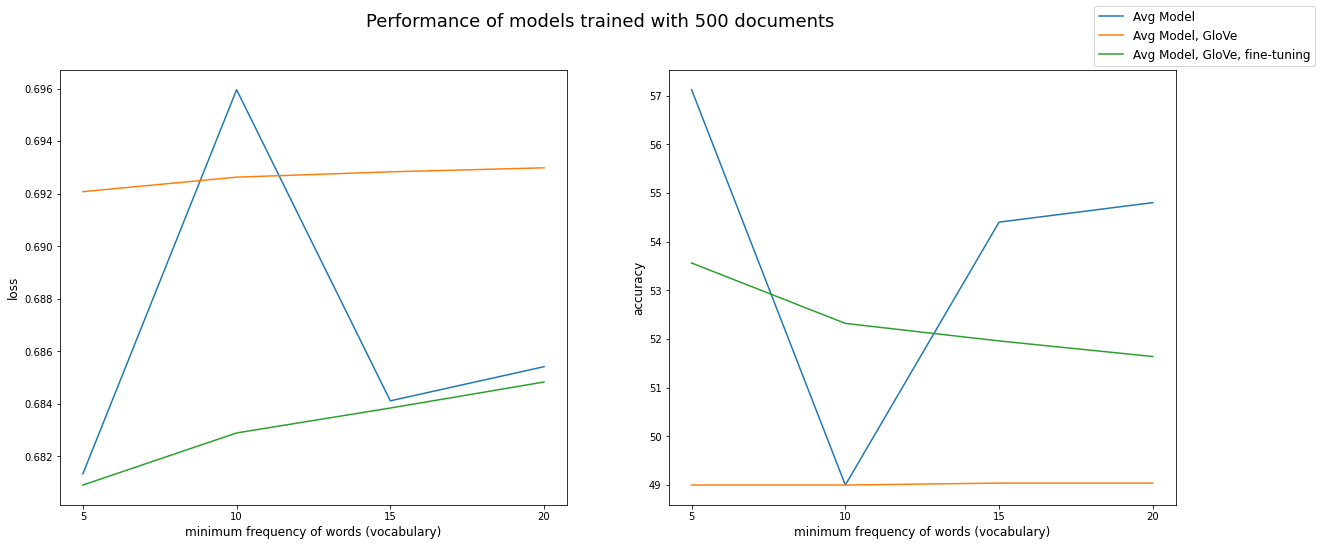

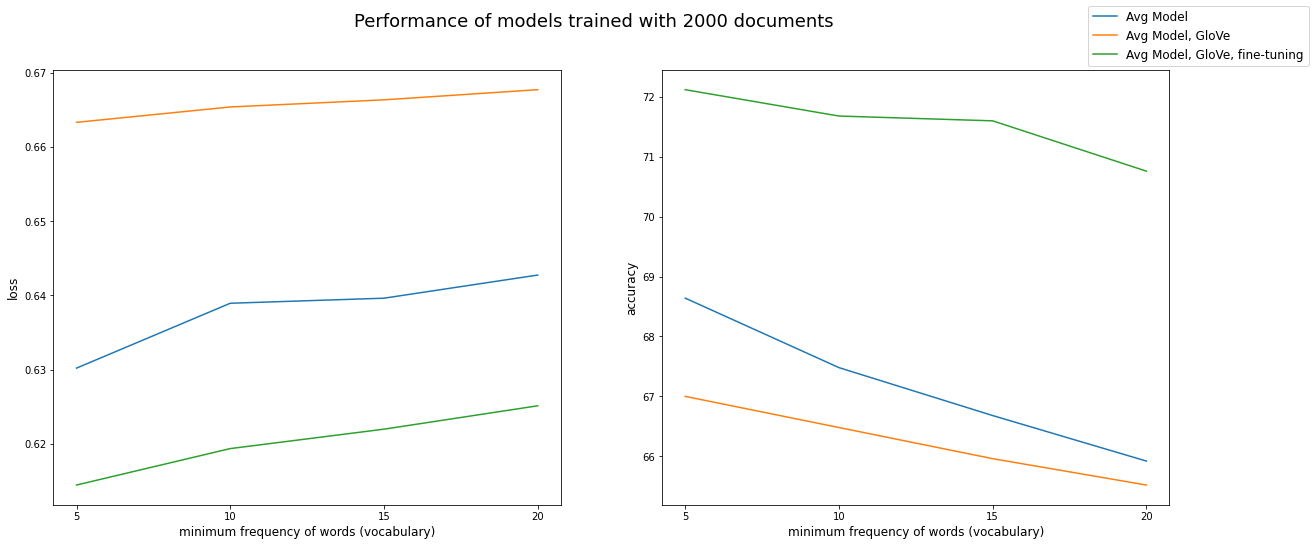

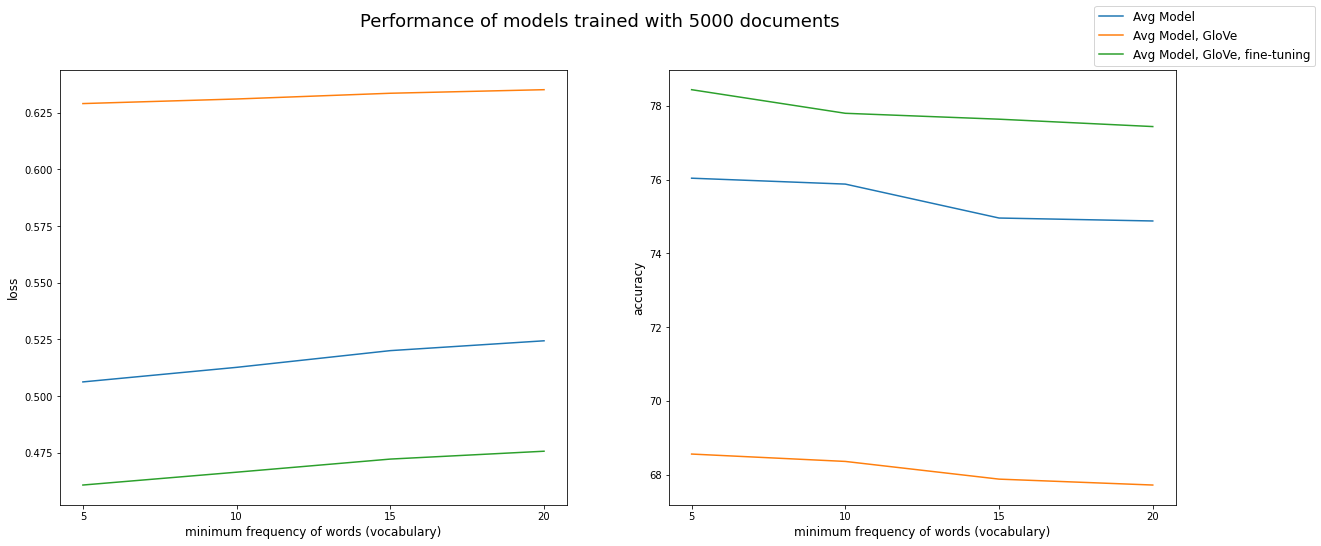

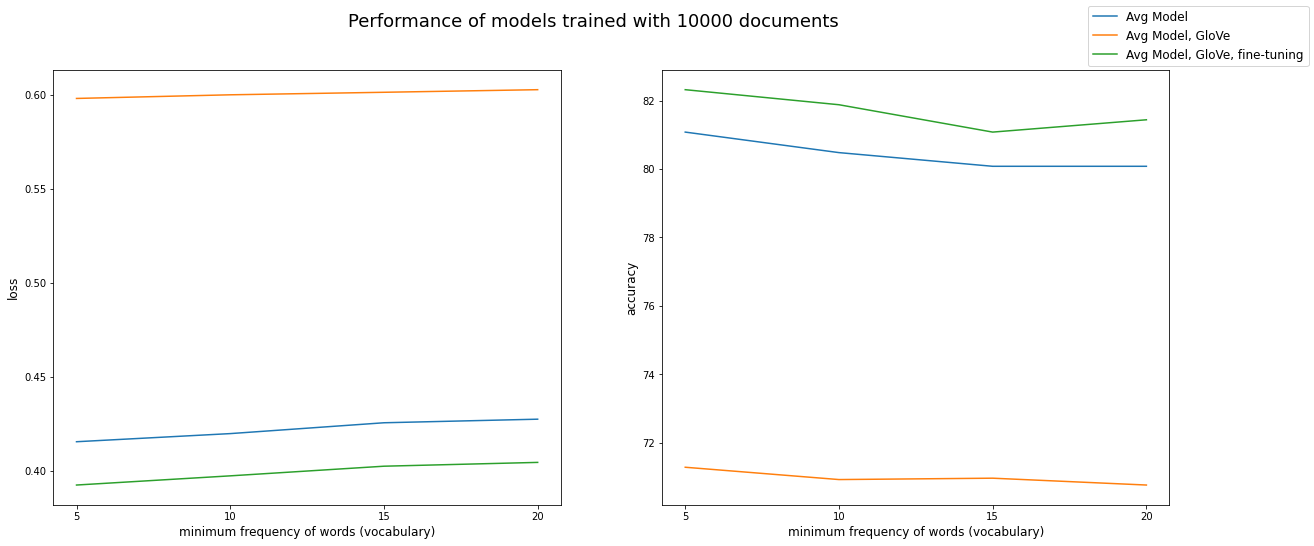

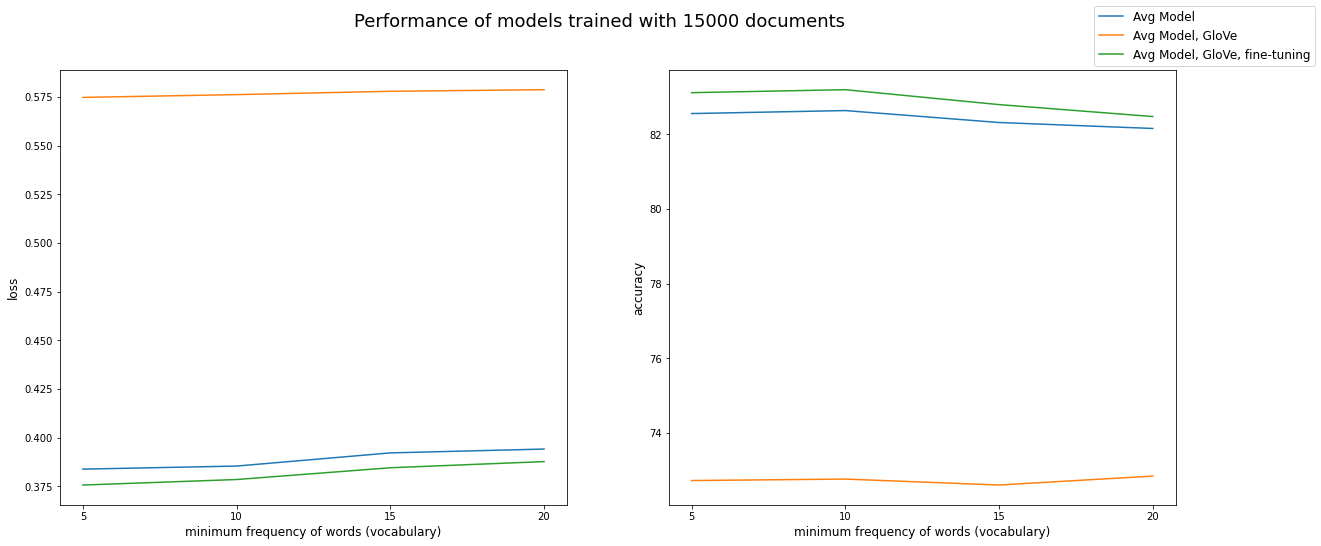

In [94]:
plot_results(general_losses, general_accuracies, models, data_sizes, min_freqs)

In [92]:
show_results(general_losses, general_accuracies, models, data_sizes, min_freqs)

Experiment losses: 


min_freq                                       5         10        15  \
data_size model                                                         
500       Avg Model                      0.681341  0.695955  0.684117   
          Avg Model, GloVe               0.692075  0.692627  0.692830   
          Avg Model, GloVe, fine-tuning  0.680913  0.682895  0.683844   
2000      Avg Model                      0.630216  0.638947  0.639628   
          Avg Model, GloVe               0.663301  0.665368  0.666328   
          Avg Model, GloVe, fine-tuning  0.614479  0.619384  0.621998   
5000      Avg Model                      0.506270  0.512696  0.520071   
          Avg Model, GloVe               0.629069  0.631087  0.633623   
          Avg Model, GloVe, fine-tuning  0.460775  0.466441  0.472225   
10000     Avg Model                      0.415560  0.419881  0.425643   
          Avg Model, GloVe               0.598104  0.600039  0.601382   
          Avg Model, GloVe, fine-tuning  0.392532  0.397416  0.402544   
15000     Avg Model                      0.383901  0.385467  0.392227   
          Avg Model, GloVe               0.574721  0.576146  0.577852   
          Avg Model, GloVe, fine-tuning  0.375731  0.378555  0.384597   

min_freq                                       20  
data_size model                                    
500       Avg Model                      0.685416  
          Avg Model, GloVe               0.692983  
          Avg Model, GloVe, fine-tuning  0.684833  
2000      Avg Model                      0.642742  
          Avg Model, GloVe               0.667694  
          Avg Model, GloVe, fine-tuning  0.625145  
5000      Avg Model                      0.524410  
          Avg Model, GloVe               0.635194  
          Avg Model, GloVe, fine-tuning  0.475691  
10000     Avg Model                      0.427547  
          Avg Model, GloVe               0.602761  
          Avg Model, GloVe, fine-tuning  0.404572  
15000     Avg Model                      0.394198  
          Avg Model, GloVe               0.578677  
          Avg Model, GloVe, fine-tuning  0.387763


Experiment accuracies: 


min_freq                                    5      10     15     20
data_size model                                                    
500       Avg Model                      57.12  49.00  54.40  54.80
          Avg Model, GloVe               49.00  49.00  49.04  49.04
          Avg Model, GloVe, fine-tuning  53.56  52.32  51.96  51.64
2000      Avg Model                      68.64  67.48  66.68  65.92
          Avg Model, GloVe               67.00  66.48  65.96  65.52
          Avg Model, GloVe, fine-tuning  72.12  71.68  71.60  70.76
5000      Avg Model                      76.04  75.88  74.96  74.88
          Avg Model, GloVe               68.56  68.36  67.88  67.72
          Avg Model, GloVe, fine-tuning  78.44  77.80  77.64  77.44
10000     Avg Model                      81.08  80.48  80.08  80.08
          Avg Model, GloVe               71.28  70.92  70.96  70.76
          Avg Model, GloVe, fine-tuning  82.32  81.88  81.08  81.44
15000     Avg Model                      82.56  82.64  82.32  82.16
          Avg Model, GloVe               72.72  72.76  72.60  72.84
          Avg Model, GloVe, fine-tuning  83.12  83.20  82.80  82.48

### LSTM Cells in pytorch

In [98]:
# Create a toy example of LSTM: 
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# LSTMs expect inputs having 3 dimensions:
# - The first dimension is the temporal dimension, along which we (in our case) have the different words
# - The second dimension is the batch dimension, along which we stack the independant batches
# - The third dimension is the feature dimension, along which are the features of the vector representing the words

# In our toy case, we have inputs and outputs containing 3 features (third dimension !)
# We created a sequence of 5 different inputs (first dimension !)
# We don't use batch (the second dimension will have one lement)

# We need an initial hidden state, of the right sizes for dimension 2/3, but with only one temporal element:
# Here, it is:
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
# Why do we create a tuple of two tensors ? Because we use LSTMs: remember that they use two sets of weights,
# and two hidden states (Hidden state, and Cell state).
# If you don't remember, read: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
# If we used a classic RNN, we would simply have:
# hidden = torch.randn(1, 1, 3)

# The naive way of applying a lstm to inputs is to apply it one step at a time, and loop through the sequence
for i in inputs:
    # After each step, hidden contains the hidden states (remember, it's a tuple of two states).
    out, hidden = lstm(i.view(1, 1, -1), hidden)
    
# Alternatively, we can do the entire sequence all at once.
# The first value returned by LSTM is all of the Hidden states throughout the sequence.
# The second is just the most recent Hidden state and Cell state (you can compare the values)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence, for each temporal step
# "hidden" will allow you to continue the sequence and backpropagate later, with another sequence
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # Re-initialize
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[ 0.2017,  0.1820,  0.8310]],

        [[-0.0319, -0.1193,  0.2957]],

        [[ 0.0090, -0.0713,  0.5229]],

        [[-0.1860,  0.0442,  0.3198]],

        [[ 0.0613,  0.1303,  0.4998]]], grad_fn=<StackBackward>)
(tensor([[[0.0613, 0.1303, 0.4998]]], grad_fn=<StackBackward>), tensor([[[0.1169, 0.2382, 0.7661]]], grad_fn=<StackBackward>))


### Creating our own LSTM Model

We'll implement now a LSTM model, taking the same inputs and also outputing a score for the sentence.

In [105]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocabulary_size=None, embeddings=None, fine_tune=False):
        super().__init__()

        if embeddings is not None:
            embeddings = torch.from_numpy(embeddings).float()
            self.embeddings = nn.Embedding.from_pretrained(embeddings, freeze=not fine_tune, padding_idx=0)
        else:
            self.embeddings = nn.Embedding(vocabulary_size + 1, embedding_dim, padding_idx=0)
        
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        self.linear = nn.Linear(hidden_dim, 1)
        
    def forward(self, inputs):
        x = self.embeddings(inputs)

        hidden = (torch.randn(1, x.shape[0], self.hidden_dim).to(device), 
                    torch.randn(1, x.shape[0], self.hidden_dim).to(device))
        _, hidden = self.lstm(x, hidden)
        
        o = self.linear(hidden[0]).squeeze()
        return o

### LSTM Model 

In [113]:
model = LSTMModel(300, 120, len(training_word2idx))
model.to(device)
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

train_losses = experiment(model, opt, criterion, training_dataloader, valid_dataloader, test_dataloader)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.7035883069038391; training acc = 42.5
Batch 20 : training loss = 0.6800246834754944; training acc = 57.0
Batch 40 : training loss = 0.6823475360870361; training acc = 57.5
Batch 60 : training loss = 0.6734347939491272; training acc = 62.0
Batch 80 : training loss = 0.6681960821151733; training acc = 60.0
Epoch 1 : Validation loss = 0.6780580109357834; Validation acc = 58.28
Epoch 2:
Batch 0 : training loss = 0.6648460030555725; training acc = 66.0
Batch 20 : training loss = 0.5972133874893188; training acc = 69.5
Batch 40 : training loss = 0.612169623374939; training acc = 66.5
Batch 60 : training loss = 0.5815998315811157; training acc = 70.0
Batch 80 : training loss = 0.574020504951477; training acc = 73.0
Epoch 2 : Validation loss = 0.6103250759840012; Validation acc = 67.28
Epoch 3:
Batch 0 : training loss = 0.5423918962478638; training acc = 76.0
Batch 20 : training loss = 0.5272833704948425; training acc = 76.5
Batch 40 :

### LSTM Model, GloVe

In [114]:
model = LSTMModel(300, 120, embeddings=GloveEmbeddings)
model.to(device)
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

train_losses = experiment(model, opt, criterion, training_dataloader, valid_dataloader, test_dataloader)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6929348111152649; training acc = 54.5
Batch 20 : training loss = 0.6586942076683044; training acc = 63.0
Batch 40 : training loss = 0.6614059209823608; training acc = 61.0
Batch 60 : training loss = 0.7047425508499146; training acc = 44.0
Batch 80 : training loss = 0.6948888897895813; training acc = 49.5
Epoch 1 : Validation loss = 0.6923195731639862; Validation acc = 49.88
Epoch 2:
Batch 0 : training loss = 0.6994277834892273; training acc = 44.0
Batch 20 : training loss = 0.6878448128700256; training acc = 56.5
Batch 40 : training loss = 0.6707391142845154; training acc = 63.5
Batch 60 : training loss = 0.6648765206336975; training acc = 59.0
Batch 80 : training loss = 0.6162434220314026; training acc = 71.0
Epoch 2 : Validation loss = 0.681896544098854; Validation acc = 55.48
Epoch 3:
Batch 0 : training loss = 0.6674094796180725; training acc = 60.0
Batch 20 : training loss = 0.6241452097892761; training acc = 65.5
Batch 40 

### LSTM Model, GloVe, fine-tuning

In [115]:
model = LSTMModel(300, 120, embeddings=GloveEmbeddings, fine_tune=True)
model.to(device)
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

train_losses = experiment(model, opt, criterion, training_dataloader, valid_dataloader, test_dataloader)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6945459842681885; training acc = 48.5
Batch 20 : training loss = 0.6806632280349731; training acc = 62.0
Batch 40 : training loss = 0.6193864345550537; training acc = 67.0
Batch 60 : training loss = 0.6255421042442322; training acc = 74.5
Batch 80 : training loss = 0.7034022212028503; training acc = 47.0
Epoch 1 : Validation loss = 0.6954119652509689; Validation acc = 49.6
Epoch 2:
Batch 0 : training loss = 0.7019726634025574; training acc = 46.5
Batch 20 : training loss = 0.6840269565582275; training acc = 53.5
Batch 40 : training loss = 0.6770452260971069; training acc = 59.5
Batch 60 : training loss = 0.5429844260215759; training acc = 77.5
Batch 80 : training loss = 0.4728963375091553; training acc = 79.0
Epoch 2 : Validation loss = 0.5269197198748589; Validation acc = 71.8
Epoch 3:
Batch 0 : training loss = 0.4495140314102173; training acc = 76.0
Batch 20 : training loss = 0.3926827907562256; training acc = 83.5
Batch 40 :

In [123]:
models = {
    'LSTM Model': model_wrapper(LSTMModel, embedding_dim=300, hidden_dim=120, 
                                vocabulary_size=len(training_word2idx)),

    'LSTM Model, GloVe': model_wrapper(LSTMModel, use_pretrained_emb=True, embedding_dim=300, hidden_dim=120),

    'LSTM Model, GloVe, fine-tuning': model_wrapper(LSTMModel, use_pretrained_emb=True, 
                                                    embedding_dim=300, hidden_dim=120, fine_tune=True),
}
_optim = optim_wrapper(optim.Adam, lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

data_sizes = [500, 2000, 5000, 10000, 15000]
min_freqs = np.arange(5, 25, 5)

general_losses, general_accuracies = experiments(models, criterion, _optim, data_sizes, min_freqs)

experiments started:
--data_size: 500
----min_freq: 5
----min_freq: 10
----min_freq: 15
----min_freq: 20
--data_size: 2000
----min_freq: 5
----min_freq: 10
----min_freq: 15
----min_freq: 20
--data_size: 5000
----min_freq: 5
----min_freq: 10
----min_freq: 15
----min_freq: 20
--data_size: 10000
----min_freq: 5
----min_freq: 10
----min_freq: 15
----min_freq: 20
--data_size: 15000
----min_freq: 5
----min_freq: 10
----min_freq: 15
----min_freq: 20
experiments finished in 137.36661291122437 seconds


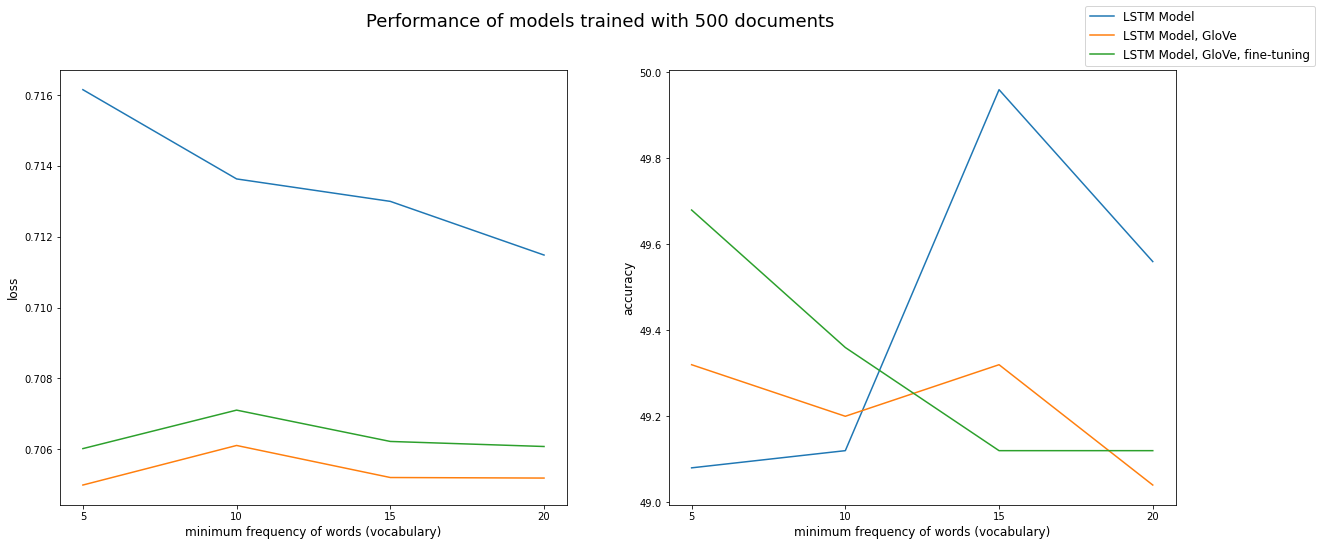

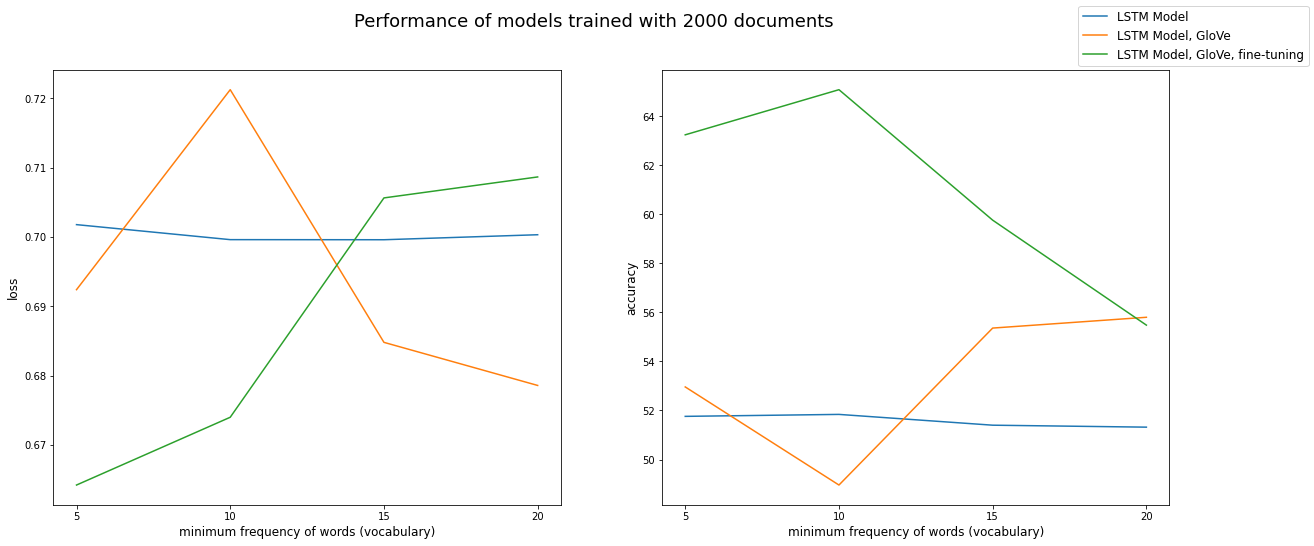

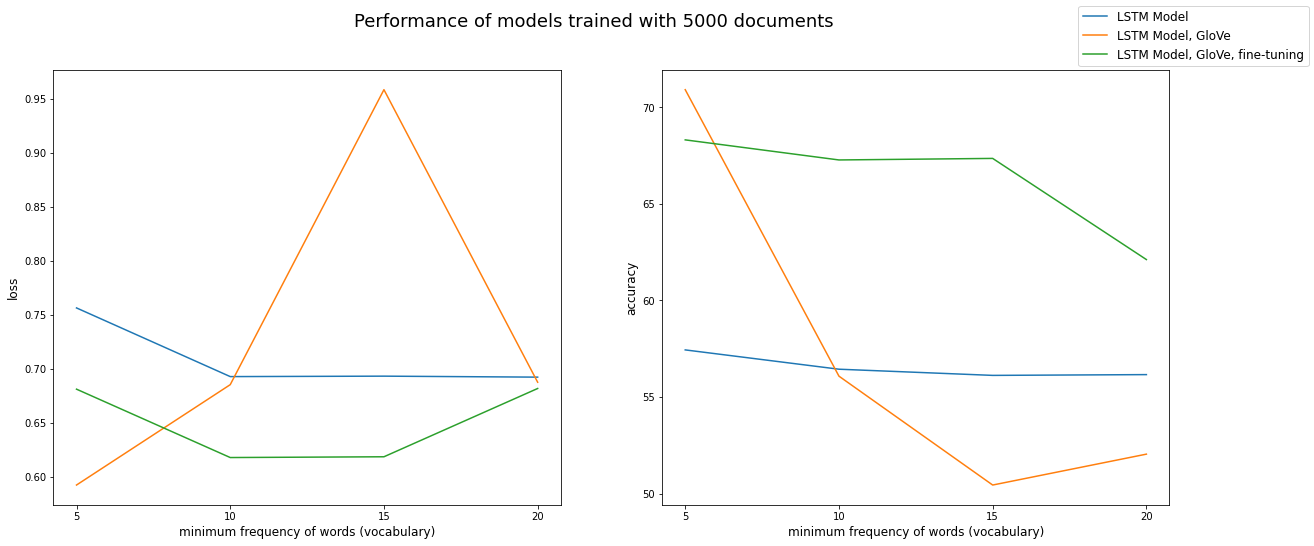

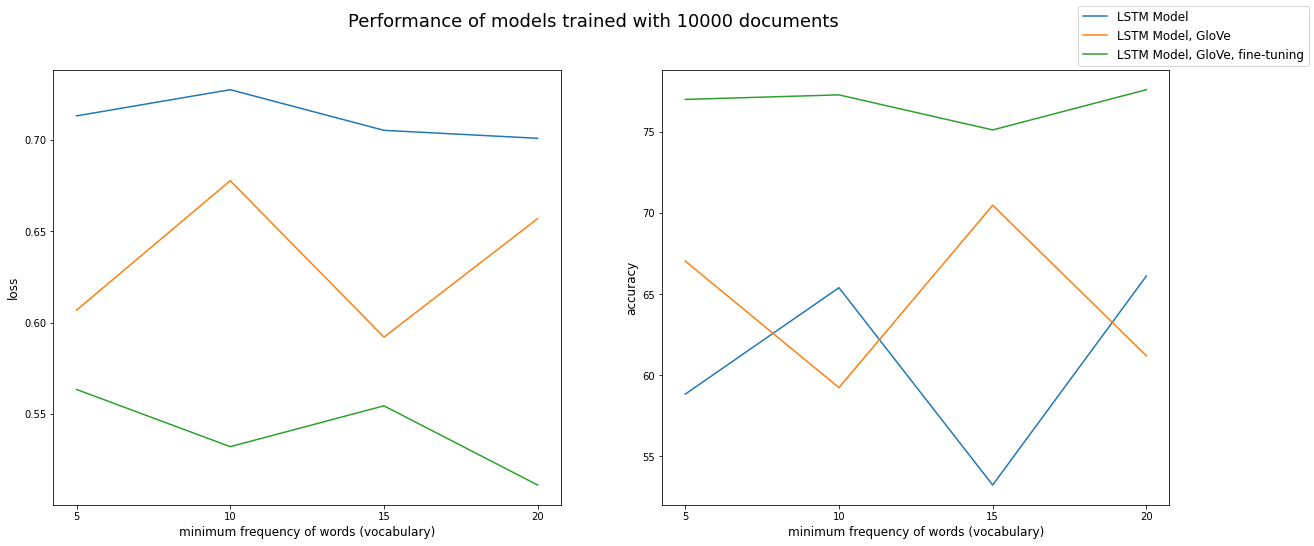

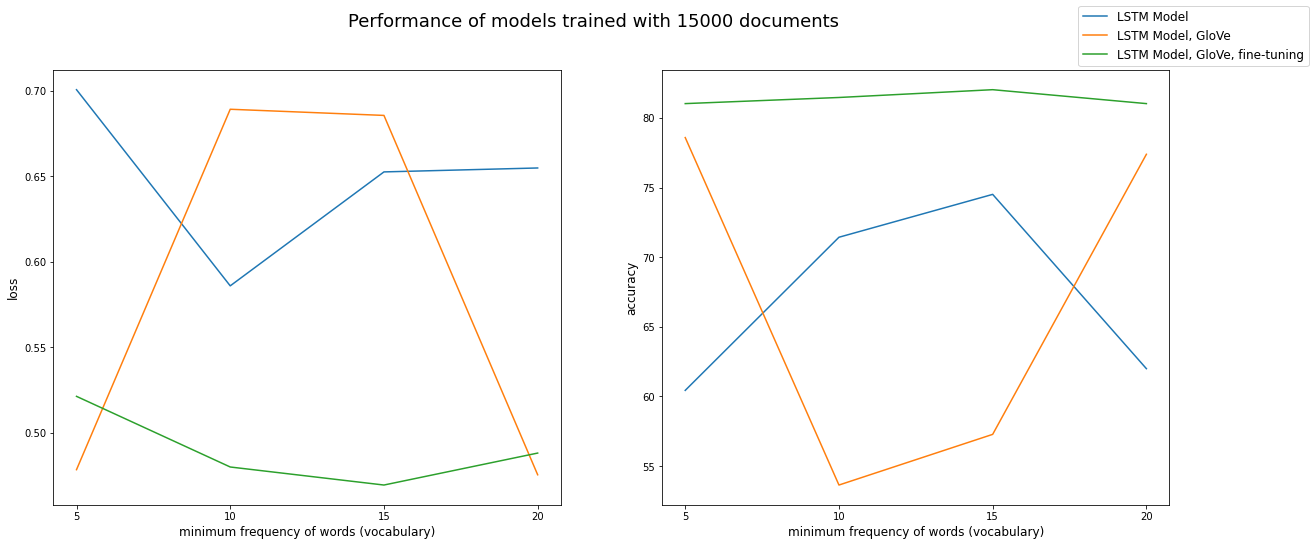

In [124]:
plot_results(general_losses, general_accuracies, models, data_sizes, min_freqs)

In [125]:
show_results(general_losses, general_accuracies, models, data_sizes, min_freqs)

Experiment losses: 


min_freq                                        5         10        15  \
data_size model                                                          
500       LSTM Model                      0.716153  0.713633  0.712999   
          LSTM Model, GloVe               0.704987  0.706105  0.705200   
          LSTM Model, GloVe, fine-tuning  0.706016  0.707103  0.706218   
2000      LSTM Model                      0.701765  0.699600  0.699586   
          LSTM Model, GloVe               0.692382  0.721232  0.684783   
          LSTM Model, GloVe, fine-tuning  0.664201  0.673979  0.705620   
5000      LSTM Model                      0.756330  0.692705  0.693118   
          LSTM Model, GloVe               0.592244  0.685221  0.958512   
          LSTM Model, GloVe, fine-tuning  0.681060  0.617715  0.618426   
10000     LSTM Model                      0.713188  0.727528  0.705282   
          LSTM Model, GloVe               0.606859  0.677702  0.592110   
          LSTM Model, GloVe, fine-tuning  0.563457  0.532154  0.554504   
15000     LSTM Model                      0.700747  0.586039  0.652669   
          LSTM Model, GloVe               0.478547  0.689305  0.685704   
          LSTM Model, GloVe, fine-tuning  0.521426  0.480114  0.469567   

min_freq                                        20  
data_size model                                     
500       LSTM Model                      0.711483  
          LSTM Model, GloVe               0.705184  
          LSTM Model, GloVe, fine-tuning  0.706076  
2000      LSTM Model                      0.700308  
          LSTM Model, GloVe               0.678568  
          LSTM Model, GloVe, fine-tuning  0.708645  
5000      LSTM Model                      0.692202  
          LSTM Model, GloVe               0.687478  
          LSTM Model, GloVe, fine-tuning  0.681690  
10000     LSTM Model                      0.700921  
          LSTM Model, GloVe               0.656952  
          LSTM Model, GloVe, fine-tuning  0.511151  
15000     LSTM Model                      0.654968  
          LSTM Model, GloVe               0.475576  
          LSTM Model, GloVe, fine-tuning  0.488258


Experiment accuracies: 


min_freq                                     5      10     15     20
data_size model                                                     
500       LSTM Model                      49.08  49.12  49.96  49.56
          LSTM Model, GloVe               49.32  49.20  49.32  49.04
          LSTM Model, GloVe, fine-tuning  49.68  49.36  49.12  49.12
2000      LSTM Model                      51.76  51.84  51.40  51.32
          LSTM Model, GloVe               52.96  48.96  55.36  55.80
          LSTM Model, GloVe, fine-tuning  63.24  65.08  59.76  55.48
5000      LSTM Model                      57.44  56.44  56.12  56.16
          LSTM Model, GloVe               70.92  56.08  50.44  52.04
          LSTM Model, GloVe, fine-tuning  68.32  67.28  67.36  62.12
10000     LSTM Model                      58.84  65.40  53.24  66.12
          LSTM Model, GloVe               67.04  59.24  70.48  61.20
          LSTM Model, GloVe, fine-tuning  77.00  77.28  75.12  77.60
15000     LSTM Model                      60.44  71.44  74.52  62.00
          LSTM Model, GloVe               78.60  53.64  57.28  77.40
          LSTM Model, GloVe, fine-tuning  81.04  81.48  82.04  81.04

### And with a CNN ? 

In [126]:
class CNNModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size=None, embeddings=None, window_size: int = 16, filter_multiplier=64, fine_tune=False):
        super().__init__()
        if embeddings is not None:
            embeddings = torch.from_numpy(embeddings).float()
            self.embeddings = nn.Embedding.from_pretrained(embeddings, freeze=not fine_tune, padding_idx=0)
        else:
            self.embeddings = nn.Embedding(vocabulary_size + 1, embedding_dim, padding_idx=0)
        
        self.conv = nn.Conv1d(embedding_dim, filter_multiplier, window_size)
        self.maxpool = nn.MaxPool1d(2)

        self.linear = nn.Linear(filter_multiplier, 1)

    def forward(self, inputs): 
        # A compléter
        x = self.embeddings(inputs)
        
        x = self.conv(x.view(-1, x.shape[2], x.shape[1]))
        x = torch.relu(x)
        x = self.maxpool(x)
        
        x = x.mean(dim=2)
        o = self.linear(x).squeeze()
        return o

### CNN model

In [128]:
model = CNNModel(300, len(training_word2idx))
model.to(device)
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

train_losses = experiment(model, opt, criterion, training_dataloader, valid_dataloader, test_dataloader)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6936401128768921; training acc = 51.5
Batch 20 : training loss = 0.6966436505317688; training acc = 53.5
Batch 40 : training loss = 0.6878791451454163; training acc = 54.5
Batch 60 : training loss = 0.643783688545227; training acc = 59.5
Batch 80 : training loss = 0.5771055221557617; training acc = 68.0
Epoch 1 : Validation loss = 0.5011475077271461; Validation acc = 76.0
Epoch 2:
Batch 0 : training loss = 0.451535165309906; training acc = 79.5
Batch 20 : training loss = 0.3623284697532654; training acc = 85.0
Batch 40 : training loss = 0.30918726325035095; training acc = 87.5
Batch 60 : training loss = 0.35109931230545044; training acc = 85.0
Batch 80 : training loss = 0.28901270031929016; training acc = 89.5
Epoch 2 : Validation loss = 0.41080446034669876; Validation acc = 81.64
Epoch 3:
Batch 0 : training loss = 0.15593357384204865; training acc = 98.0
Batch 20 : training loss = 0.16936485469341278; training acc = 95.0
Batch

### CNN model, GloVe

In [129]:
model = CNNModel(300, embeddings=GloveEmbeddings)
model.to(device)
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

train_losses = experiment(model, opt, criterion, training_dataloader, valid_dataloader, test_dataloader)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6926754713058472; training acc = 59.0
Batch 20 : training loss = 0.707712709903717; training acc = 53.0
Batch 40 : training loss = 0.6619682908058167; training acc = 60.5
Batch 60 : training loss = 0.6417955160140991; training acc = 65.5
Batch 80 : training loss = 0.6185290217399597; training acc = 68.5
Epoch 1 : Validation loss = 0.6158958691358566; Validation acc = 67.84
Epoch 2:
Batch 0 : training loss = 0.5864286422729492; training acc = 70.0
Batch 20 : training loss = 0.5600259304046631; training acc = 70.5
Batch 40 : training loss = 0.6031967401504517; training acc = 67.0
Batch 60 : training loss = 0.5961782932281494; training acc = 68.0
Batch 80 : training loss = 0.519615650177002; training acc = 78.5
Epoch 2 : Validation loss = 0.5787441071867943; Validation acc = 69.6
Epoch 3:
Batch 0 : training loss = 0.5067958235740662; training acc = 78.0
Batch 20 : training loss = 0.498670369386673; training acc = 79.0
Batch 40 : t

### CNN model, GloVe, fine-tuning

In [131]:
model = CNNModel(300, embeddings=GloveEmbeddings, fine_tune=True)
model.to(device)
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

train_losses = experiment(model, opt, criterion, training_dataloader, valid_dataloader, test_dataloader)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.6961250305175781; training acc = 46.0
Batch 20 : training loss = 0.6289306282997131; training acc = 68.0
Batch 40 : training loss = 0.518305242061615; training acc = 74.0
Batch 60 : training loss = 0.48631277680397034; training acc = 77.5
Batch 80 : training loss = 0.4399574100971222; training acc = 79.0
Epoch 1 : Validation loss = 0.3861797434091568; Validation acc = 82.12
Epoch 2:
Batch 0 : training loss = 0.2996417284011841; training acc = 88.5
Batch 20 : training loss = 0.24637100100517273; training acc = 89.5
Batch 40 : training loss = 0.2773931324481964; training acc = 89.5
Batch 60 : training loss = 0.2660648226737976; training acc = 92.0
Batch 80 : training loss = 0.20971082150936127; training acc = 94.0
Epoch 2 : Validation loss = 0.4129882185161114; Validation acc = 82.2
Early stopping.
Epoch 2 : Test loss = 0.40819288350641725; Test acc = 82.8


In [132]:
models = {
    'CNN Model': model_wrapper(CNNModel, embedding_dim=300, vocabulary_size=len(training_word2idx)),

    'CNN Model, GloVe': model_wrapper(CNNModel, use_pretrained_emb=True, embedding_dim=300),

    'CNN Model, GloVe, fine-tuning': model_wrapper(CNNModel, use_pretrained_emb=True, 
                                                    embedding_dim=300, fine_tune=True),
}
_optim = optim_wrapper(optim.Adam, lr=0.0025, betas=(0.9, 0.999))
criterion = nn.BCEWithLogitsLoss()

data_sizes = [500, 2000, 5000, 10000, 15000]
min_freqs = np.arange(5, 25, 5)

general_losses, general_accuracies = experiments(models, criterion, _optim, data_sizes, min_freqs)

experiments started:
--data_size: 500
----min_freq: 5
----min_freq: 10
----min_freq: 15
----min_freq: 20
--data_size: 2000
----min_freq: 5
----min_freq: 10
----min_freq: 15
----min_freq: 20
--data_size: 5000
----min_freq: 5
----min_freq: 10
----min_freq: 15
----min_freq: 20
--data_size: 10000
----min_freq: 5
----min_freq: 10
----min_freq: 15
----min_freq: 20
--data_size: 15000
----min_freq: 5
----min_freq: 10
----min_freq: 15
----min_freq: 20
experiments finished in 97.27837777137756 seconds


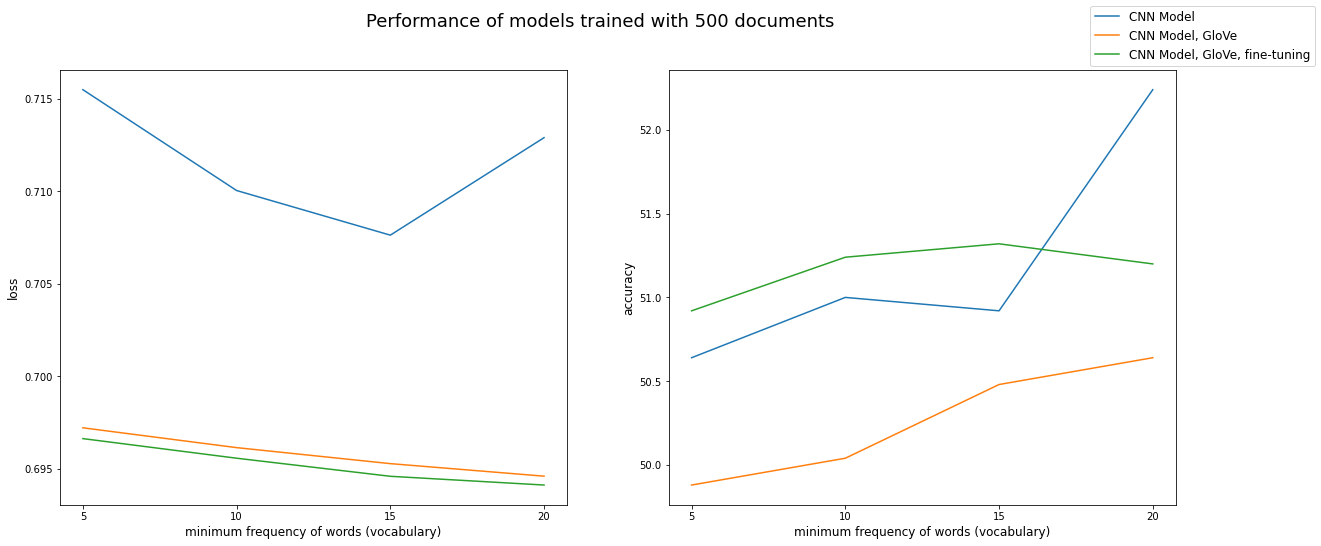

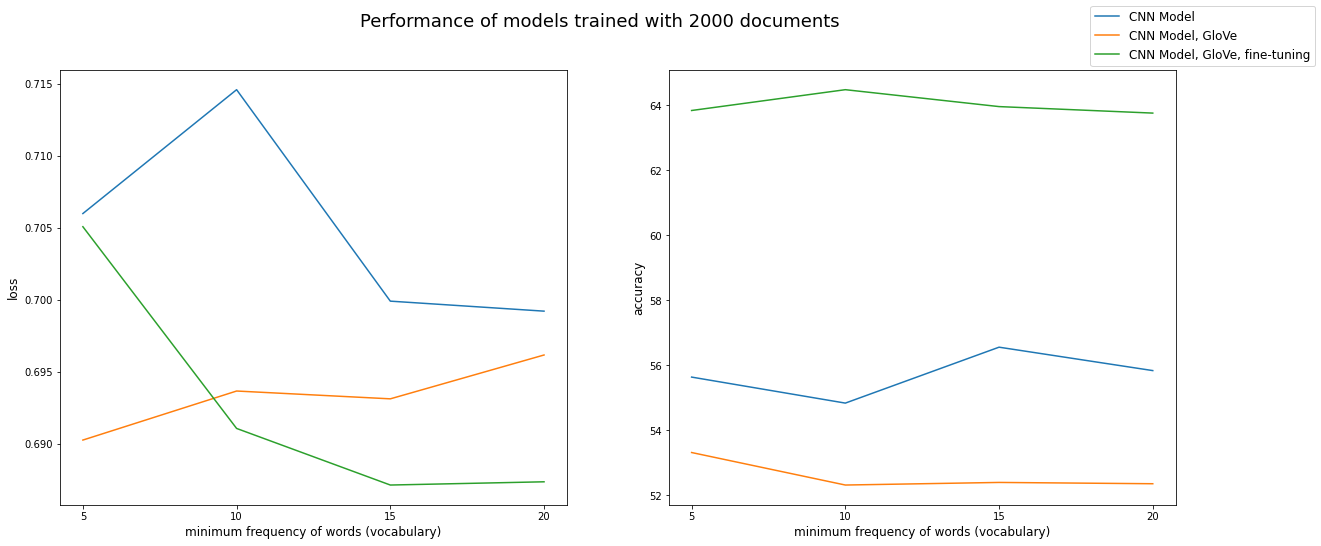

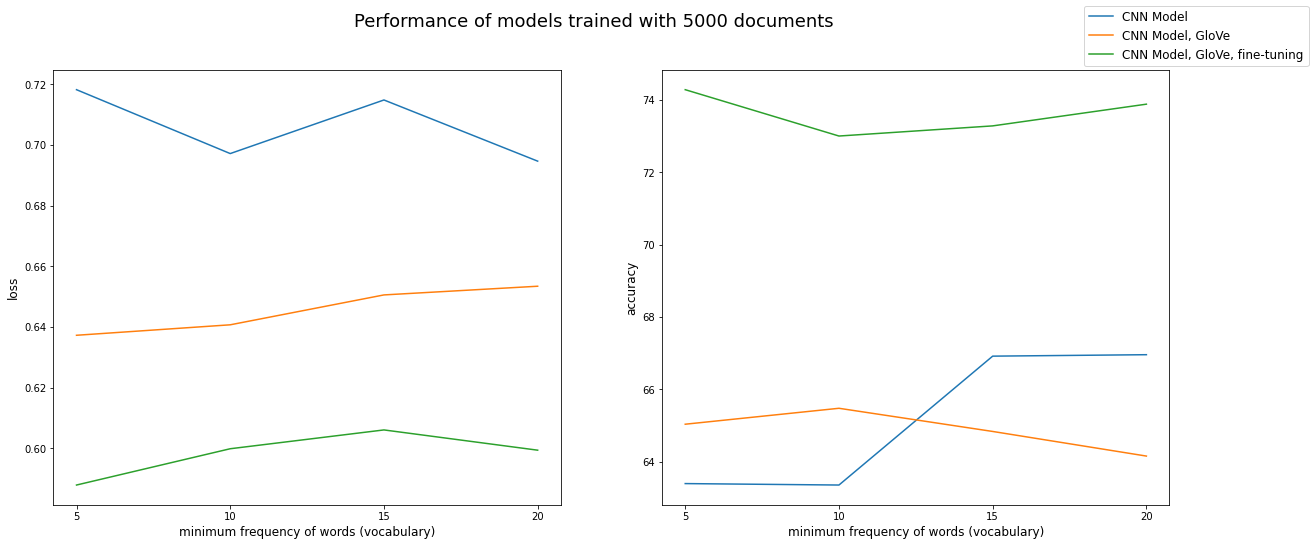

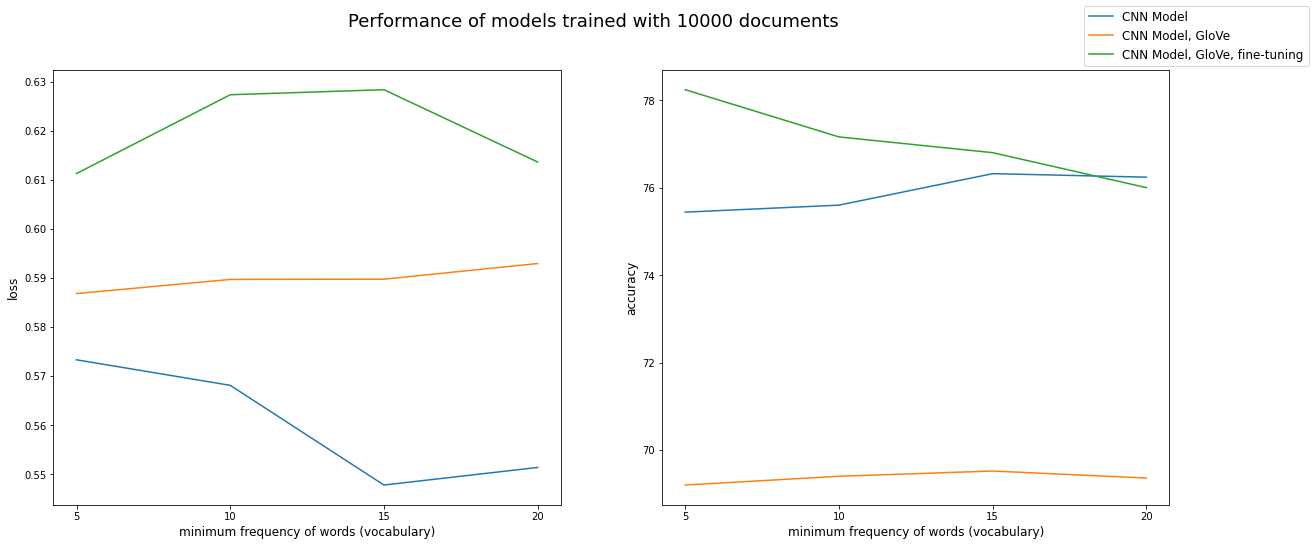

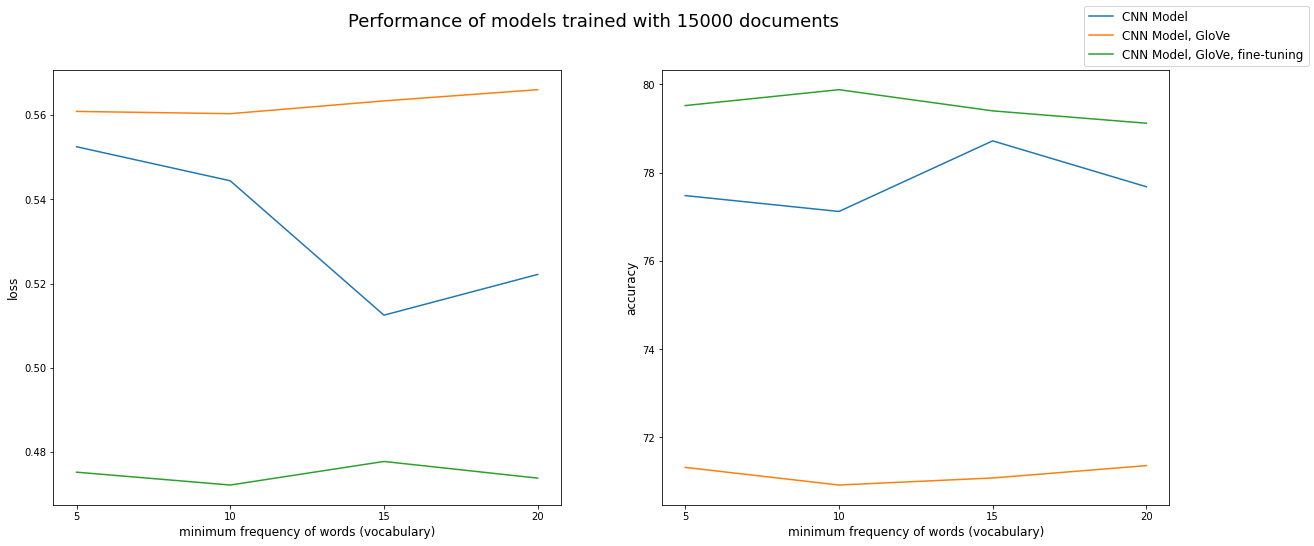

In [133]:
plot_results(general_losses, general_accuracies, models, data_sizes, min_freqs)

In [134]:
show_results(general_losses, general_accuracies, models, data_sizes, min_freqs)

Experiment losses: 


min_freq                                       5         10        15  \
data_size model                                                         
500       CNN Model                      0.715497  0.710042  0.707627   
          CNN Model, GloVe               0.697206  0.696133  0.695268   
          CNN Model, GloVe, fine-tuning  0.696621  0.695561  0.694583   
2000      CNN Model                      0.706005  0.714605  0.699922   
          CNN Model, GloVe               0.690275  0.693681  0.693138   
          CNN Model, GloVe, fine-tuning  0.705090  0.691082  0.687153   
5000      CNN Model                      0.718237  0.697174  0.714845   
          CNN Model, GloVe               0.637264  0.640715  0.650568   
          CNN Model, GloVe, fine-tuning  0.587885  0.599851  0.606053   
10000     CNN Model                      0.573315  0.568113  0.547805   
          CNN Model, GloVe               0.586802  0.589685  0.589737   
          CNN Model, GloVe, fine-tuning  0.611257  0.627306  0.628337   
15000     CNN Model                      0.552487  0.544404  0.512498   
          CNN Model, GloVe               0.560872  0.560330  0.563369   
          CNN Model, GloVe, fine-tuning  0.475227  0.472176  0.477772   

min_freq                                       20  
data_size model                                    
500       CNN Model                      0.712900  
          CNN Model, GloVe               0.694589  
          CNN Model, GloVe, fine-tuning  0.694110  
2000      CNN Model                      0.699227  
          CNN Model, GloVe               0.696183  
          CNN Model, GloVe, fine-tuning  0.687377  
5000      CNN Model                      0.694676  
          CNN Model, GloVe               0.653433  
          CNN Model, GloVe, fine-tuning  0.599376  
10000     CNN Model                      0.551386  
          CNN Model, GloVe               0.592926  
          CNN Model, GloVe, fine-tuning  0.613602  
15000     CNN Model                      0.522171  
          CNN Model, GloVe               0.566028  
          CNN Model, GloVe, fine-tuning  0.473817


Experiment accuracies: 


min_freq                                    5      10     15     20
data_size model                                                    
500       CNN Model                      50.64  51.00  50.92  52.24
          CNN Model, GloVe               49.88  50.04  50.48  50.64
          CNN Model, GloVe, fine-tuning  50.92  51.24  51.32  51.20
2000      CNN Model                      55.64  54.84  56.56  55.84
          CNN Model, GloVe               53.32  52.32  52.40  52.36
          CNN Model, GloVe, fine-tuning  63.84  64.48  63.96  63.76
5000      CNN Model                      63.40  63.36  66.92  66.96
          CNN Model, GloVe               65.04  65.48  64.84  64.16
          CNN Model, GloVe, fine-tuning  74.28  73.00  73.28  73.88
10000     CNN Model                      75.44  75.60  76.32  76.24
          CNN Model, GloVe               69.20  69.40  69.52  69.36
          CNN Model, GloVe, fine-tuning  78.24  77.16  76.80  76.00
15000     CNN Model                      77.48  77.12  78.72  77.68
          CNN Model, GloVe               71.32  70.92  71.08  71.36
          CNN Model, GloVe, fine-tuning  79.52  79.88  79.40  79.12

### Questions: 
- What do you see with a simple application of LSTMs and CNNs models ? 
- Similarly, make hypothesis based on your intuition and the class on how
    - the number of documents 
    - the size of the vocabulary 
  will impact results, in the three cases (No pre-training, pre-training without fine-tuning, pretraining with fine-tuning) for the LSTM **or** CNN (and the CNN should be quite faster !) and verify your hypothesis with experiments and analyze your results !
- Present your results in a clear and synthetic way (table, figures) and be careful to experimental methodology. Notably, you should fix hyperparameters before making comparisons (you should use maximum length of sentences and batch sizes to accelerate training - similarly, using a SGD optimizer will be faster than Adam) ! 